In [ ]:
import pandas as pd
import os

folder_path = "C:/Users/Reffa/ai_project_env/Dataset/" 

print("Съдържание на директорията:")
print(os.listdir(folder_path))

listings_df = pd.read_csv(os.path.join(folder_path, "listings.csv"))
availabilities_df = pd.read_csv(os.path.join(folder_path, "availabilities.csv"))
hosts_df = pd.read_csv(os.path.join(folder_path, "hosts.csv"))
reviews_df = pd.read_csv(os.path.join(folder_path, "reviews.csv"))

print("\nПървите 5 реда от listings.csv:")
print(listings_df.head())

print("\nПървите 5 реда от availabilities.csv:")
print(availabilities_df.head())

print("\nПървите 5 реда от hosts.csv:")
print(hosts_df.head())

print("\nПървите 5 реда от reviews.csv:")
print(reviews_df.head())



Файлът е успешно зареден от: C:\Users\Reffa\ai_project_env\reviews.csv
Точност на модела за класификация на отзиви: 96.92%

Класификационен отчет:
              precision    recall  f1-score   support

           0       0.80      0.44      0.57      3220
           1       0.97      0.99      0.98     66915

    accuracy                           0.97     70135
   macro avg       0.88      0.72      0.78     70135
weighted avg       0.97      0.97      0.96     70135


Първите 30 реда с присвоени клъстери:
                                             comments  cluster
0   it's a wonderful trip experience. I didn't exc...      1.0
1   This is my first trip using Airbnb. I was a li...      1.0
2   The reservation was canceled 80 days before ar...      1.0
3   Sólo puedo decir cosas buenas de Rebecca. La h...      1.0
4   Rebecca was an absolutely wonderful host.\r\n\...      1.0
5   Rebecca really tried to make it feel like home...      1.0
6   Hi. i just return from Chicago and want to

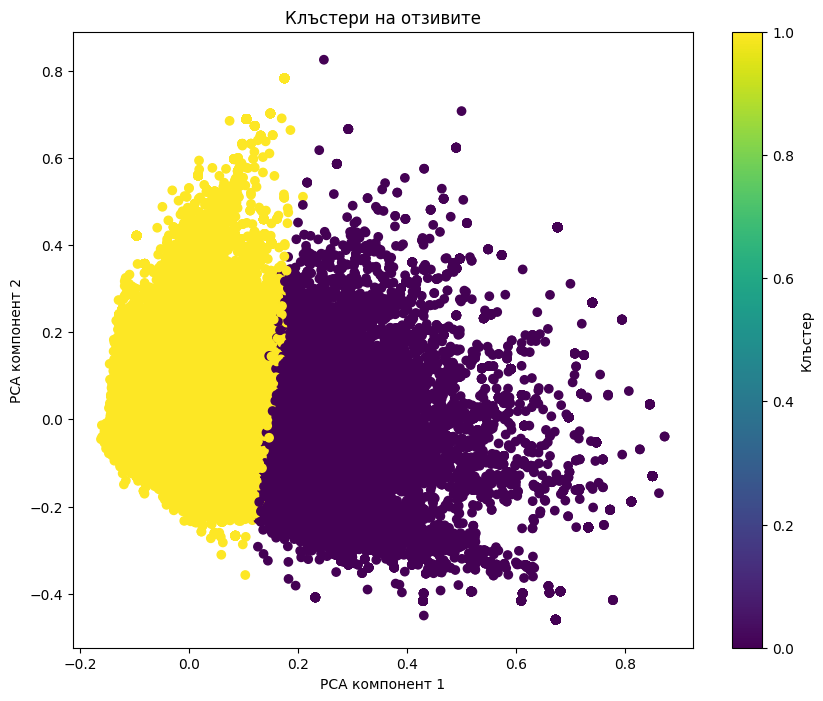

In [1]:
import pandas as pd
from textblob import TextBlob
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Определяме пътя към файла reviews.csv
file_path = os.path.join(os.getcwd(), "reviews.csv")

# Прочитане на данните
try:
    reviews_df = pd.read_csv(file_path)
    print(f"Файлът е успешно зареден от: {file_path}")
except FileNotFoundError:
    print(f"Файлът не беше намерен на пътя: {file_path}")
    raise

# Уверяваме се, че колоната 'comments' съдържа само низове
reviews_df['comments'] = reviews_df['comments'].fillna('').astype(str)

# Функция за анализ на чувствителността с TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return 1 if sentiment > 0 else 0  # Положителен ако полярността е > 0, в противен случай отрицателен

# Прилагане на анализа на чувствителността към колоната 'comments'
reviews_df['label'] = reviews_df['comments'].apply(get_sentiment)

# Разделяне на данните на X (текст) и y (целева променлива)
X = reviews_df['comments']
y = reviews_df['label']

# Разделяме на тренировъчни и тестови данни (80% за тренировка, 20% за тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуване на текстовете в числови стойности с TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Създаване на модел за класификация (Naive Bayes)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Прогнозиране на резултатите
y_pred = model.predict(X_test_tfidf)

# Оценка на точността на класификатора
accuracy = accuracy_score(y_test, y_pred)
print(f"Точност на модела за класификация на отзиви: {accuracy * 100:.2f}%")
print("\nКласификационен отчет:")
print(classification_report(y_test, y_pred))

# --- Сега преминаваме към клъстеризацията на отзивите ---

# Прилагане на KMeans клъстеризация (например 2 клъстера)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_tfidf)

# Присвояване на кластерите към тренировъчните данни
reviews_df.loc[X_train.index, 'cluster'] = kmeans.predict(X_train_tfidf)

# Ако искаш да включиш и тестовите данни
reviews_df.loc[X_test.index, 'cluster'] = kmeans.predict(X_test_tfidf)

# Показване на първите няколко резултата за клъстеризация
print("\nПървите 30 реда с присвоени клъстери:")
print(reviews_df[['comments', 'cluster']].head(30))

# Визуализация на клъстерите с PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

# Плотираме резултатите
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("Клъстери на отзивите")
plt.xlabel("PCA компонент 1")
plt.ylabel("PCA компонент 2")
plt.colorbar(label="Клъстер")
plt.show()
